In [1]:
import jax
from jax import numpy as np
from jax import scipy as sp
from jax import random

import numpy as onp
from numpy.polynomial.hermite import hermgauss

import paragami

# GMM libraries
import bnpgmm_runjingdev.gmm_clustering_lib as gmm_lib
import bnpgmm_runjingdev.utils_lib as utils_lib
import bnpgmm_runjingdev.gmm_optimization_lib as gmm_optim_lib
from bnpgmm_runjingdev import gmm_posterior_quantities_lib

# BNP libraries
from bnpmodeling_runjingdev.sensitivity_lib import HyperparameterSensitivityLinearApproximation, get_cross_hess
from bnpmodeling_runjingdev import result_loading_utils, influence_lib
import bnpmodeling_runjingdev.functional_sensitivity_lib as func_sens_lib

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm

from sklearn.decomposition import PCA

from copy import deepcopy

import time

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
import influence_function_utils
import gmm_loading_utils

# Load data

We load and plot the iris dataset

In [3]:
# load iris data
dataset_name = 'iris'
iris_obs, iris_species = utils_lib.load_iris_data()
dim = iris_obs.shape[1]
n_obs = len(iris_species)

iris_obs = np.array(iris_obs)

Text(0, 0.5, 'PC2')

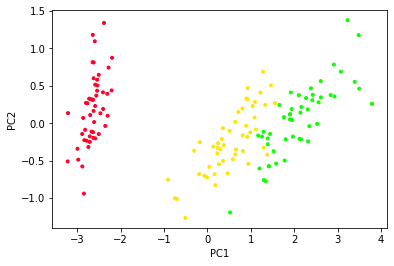

In [4]:
# run PCA
pca_fit = PCA()
pca_fit.fit(iris_obs)
pc_iris_obs = pca_fit.transform(iris_obs)

# plot
cmap = cm.get_cmap(name='gist_rainbow')
colors1 = [cmap(k * 50) for k in range(30)]

fig1 = plt.figure(1)
fig = fig1.add_subplot(111)
utils_lib.plot_clusters(pc_iris_obs[:, 0], pc_iris_obs[:, 1], iris_species, colors1, fig)
fig.set_xlabel('PC1')
fig.set_ylabel('PC2')


# file paths

In [5]:
out_folder = '../fits_20210327/'
out_filename = 'iris_fit'

In [6]:
alpha0 = 6.0

# Load initial fit

In [7]:
init_fit_file = out_folder + out_filename + '_alpha' + str(alpha0) + '.npz'
print(init_fit_file)

../fits_20210327/iris_fit_alpha6.0.npz


In [8]:
vb_opt, vb_opt_dict, e_z_opt, \
     vb_params_paragami, \
        prior_params_dict, \
            gh_loc, gh_weights = gmm_loading_utils.load_initial_fit(init_fit_file, iris_obs)

In [9]:
assert prior_params_dict['dp_prior_alpha'] == alpha0

### Check results

In [10]:
def plot_results_from_vb_params_dict(pca_fit, vb_params_dict, e_z, fig): 
    # we plot in PCA space
    bnp_centroids_pc, bnp_cluster_covs_pc = \
        utils_lib.transform_params_to_pc_space(pca_fit, vb_params_dict['cluster_params']['centroids'], 
                                               np.linalg.inv(vb_params_dict['cluster_params']['cluster_info']))
    
    bnp_clusters = np.argmax(e_z, axis = 1)
    
    cmap = cm.get_cmap(name='gist_rainbow')
    colors1 = [cmap(k * 50) for k in range(30)]
    
    utils_lib.plot_clusters(pc_iris_obs[:, 0], pc_iris_obs[:, 1], bnp_clusters, \
                  colors1, fig, \
                  centroids = bnp_centroids_pc[np.unique(bnp_clusters), :], 
                cov = bnp_cluster_covs_pc[np.unique(bnp_clusters), :, :])


In [11]:
bnp_centroids_pc, bnp_cluster_covs_pc = \
        utils_lib.transform_params_to_pc_space(pca_fit, vb_opt_dict['cluster_params']['centroids'], 
                                               np.linalg.inv(vb_opt_dict['cluster_params']['cluster_info']))

### Plot centroids

Text(0, 0.5, 'PC2')

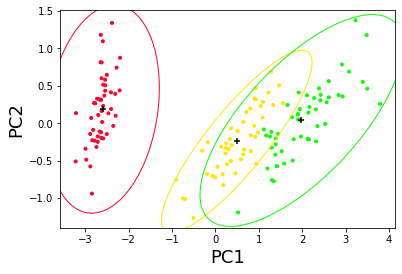

In [12]:
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

plot_results_from_vb_params_dict(pca_fit, vb_opt_dict, e_z_opt, fig)
fig.set_xlabel('PC1', fontsize = 18)
fig.set_ylabel('PC2', fontsize = 18)


# Some wrappers to compute the influence function and posterior statistics

In [13]:
# contains methods to compute influence functions. 
# this compiles the hessian solver, so takes about a minute
infl_funs = influence_function_utils.InfluenceFunctions(iris_obs, 
                                                       vb_opt, 
                                                       vb_params_paragami, 
                                                       prior_params_dict, 
                                                       gh_loc, gh_weights)

Compiling hessian solver ...
Hessian solver compile time: 58.1028sec

Compiling cross hessian...
Cross-hessian compile time: 0.673216sec

LR sensitivity time: 0.0188355sec



In [ ]:
vb_sens = infl_funs.vb_sens

In [14]:
# contains the posterior statistics
post_stats = influence_function_utils.PosteriorStatistics(iris_obs, 
                                                          vb_params_paragami, 
                                                          gh_loc, 
                                                          gh_weights)

# Influence functions

In [15]:
logit_v_grid = np.linspace(-8, 8, 500)

In [16]:
def plot_influence_grid(influence_grid, influence_grid_x_prior, ax): 
    
    # plot y = 0 line
    for i in range(3): 
        ax[i].axhline(0, color = 'black')
    
    # plot influence function
    ax[0].plot(logit_v_grid, influence_grid, color = '#43a2ca')
    
    # plot prior
    ax[1].plot(logit_v_grid,
               influence_function_utils.p0(logit_v_grid, alpha0), 
               color = '#7bccc4')
    
    # plot influence x prior
    ax[2].plot(logit_v_grid, influence_grid_x_prior, color = '#0868ac')
        
    ax[0].set_ylabel('influence')
    ax[1].set_ylabel('prior')
    ax[2].set_ylabel('influence x prior')

### Influence function on expected number of clusters

In [17]:
# in sample
infl_num_clust, infl_x_prior_num_clust, ghess_num_clust = \
    infl_funs.get_influence(post_stats.get_n_clusters_insample, 
                            logit_v_grid)

computing gradient ...
Elapsed: 7.339sec
inverting Hessian (twice) ...
Elapsed: 5.852sec


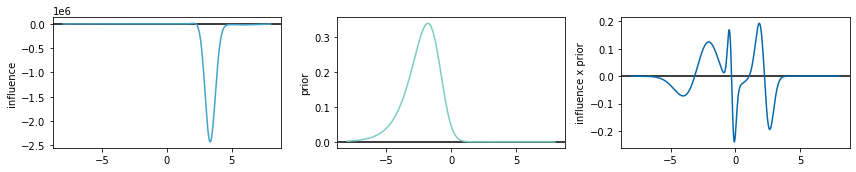

In [18]:
fig, axarr = plt.subplots(1, 3, figsize = (12, 2.5),  sharex = True) 

plot_influence_grid(infl_num_clust,
                    infl_x_prior_num_clust,
                    axarr)


fig.tight_layout()

In [19]:
worst_case = influence_lib.WorstCasePerturbation(influence_fun = None, 
                                                    logit_v_grid = logit_v_grid, 
                                                    delta = 1.,
                                                    cached_influence_grid = infl_num_clust)

In [20]:
worst_case.change_points

DeviceArray([-3.15831663, -0.30460922,  1.04208417,  2.22845691], dtype=float64)

# Functions to run experiments for different perturbations

In [ ]:
def get_lr_derivatives(f_obj, epsilon_vec): 
    # g is the posterior statistic
    # g-hess is the gradient of g times the hessian inverse
    # f_obj contains the perturbation
    
    # set derivative 
    vb_sens._set_cross
    
    return lr_g_array

In [ ]:
def get_refit_results(f_obj, epsilon_vec): 
    
    # f_obj contains the perturbation 
    
    # this function refits 
    # refits for all epsilon in epsilon_vec
    
    # define objective 
    def _f(vb_free, epsilon): 
        
        vb_params_dict = vb_params_paragami.fold(vb_free, 
                                                 free = True)

        return gmm_lib.get_kl(iris_obs, 
                              vb_params_dict,
                              prior_params_dict,
                              gh_loc, gh_weights, 
                              e_log_phi = lambda x, y : f_obj.e_log_phi_epsilon(x, y, epsilon))
    
    
    # jit functions and gradients
    f = jax.jit(_f)
    get_grad = jax.jit(jax.grad(_f, 0))
    
    def _get_hvp(x, epsilon, v):
        return jax.jvp(jax.grad(_f, argnums = 0), (x, epsilon), (v, 0.))[1]

    get_hvp = jax.jit(_get_hvp)
    
    # optimize
    vb_refit_list = []
    for epsilon in epsilon_vec: 
        print('\n################')
        print('re-optimzing with epsilon = ', epsilon)
        print('################')

        vb_opt_pert = optimize_kl(lambda x : f(x, epsilon),
                                 deepcopy(vb_opt_dict), 
                                 vb_params_paragami, 
                                 get_grad = lambda x : get_grad(x, epsilon),
                                 get_hvp = lambda x, v: get_hvp(x, epsilon, v),
                                 run_lbfgs = False,
                                 run_newton = True)[1]                             
        
        vb_refit_list.append(vb_opt_pert)
        
    return vb_refit_list